In [2]:
# Set things up.

# Make Matplotlib to work with Jupyter Notebook
%matplotlib inline

# Ignore ugly DeprecationWarnings
#from bokeh import BokehDeprecationWarning
#import warnings
#warnings.filterwarnings("ignore", category=BokehDeprecationWarning)

import datetime
import calendar

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors
from bokeh.io import output_notebook
from bokeh.plotting import show
from bokeh.layouts import row
from bokeh.models import ColumnDataSource, DataRange1d, HoverTool, PanTool, WheelZoomTool
from bokeh.models.widgets import DataTable, TableColumn
from bokeh.models.widgets import DateFormatter, StringFormatter
from bokeh.plotting import figure
import folium
from sklearn.cluster import DBSCAN
#from shapely.geometry import MultiPoint
from geopy.distance import great_circle

plt.style.use('ggplot')  # Change Matplotlib style to something nicer
plt.rc('font', size=12)  # Set default Matplotlib font size
output_notebook(hide_banner=True)  # Make Bokeh to work with Jupyter Notebook

# Define colors
COLOR_DARK = "#212121"
COLOR_YELLOW = "#ffb700"
# Define custom colormap
plt.register_cmap(cmap=colors.LinearSegmentedColormap.from_list(
    'TaxiYellow', ["#ffffff", COLOR_YELLOW]))

In [3]:
train = pd.read_csv(filepath_or_buffer="E:/1Prep for data science/capstone-1/train.csv", index_col='id',
                    parse_dates=['pickup_datetime', 'dropoff_datetime'],
                    infer_datetime_format=True)



In [4]:
test = pd.read_csv(filepath_or_buffer="E:/1Prep for data science/capstone-1/test.csv", index_col='id',
                    parse_dates=['pickup_datetime'],
                    infer_datetime_format=True)

## Shape of data and missing values info before cleanup

In [9]:
n_train_rows, n_train_cols = train.shape
n_test_rows, n_test_cols = test.shape
print('- Training data has {:9,} rows and {:2,} columns.'.format(*train.shape))
print('- Testing data has  {:9,} rows and {:2,} columns.'.format(*test.shape))

- Training data has 1,456,540 rows and 10 columns.
- Testing data has    625,134 rows and  8 columns.


## Cleaning up trip duration
As we noted earlier there are some outliers associated with the `trip_duration` variable, specifically a 980 hour maximum trip duration and a minimum of 1 second trip duration. I've decided to exclude data that lies outside 2 standard deviations from the mean. It might be worthwhile looking into what effect excluding up to 4 standard deviations would have on the end-results.

In [7]:
m = np.mean(train['trip_duration'])
s = np.std(train['trip_duration'])
train = train[train['trip_duration'] <= m + 2*s]
train = train[train['trip_duration'] >= m - 2*s]

In [8]:
n_train_rows, n_train_cols = train.shape
n_test_rows, n_test_cols = test.shape
print('- Training data has {:9,} rows and {:2,} columns.'.format(*train.shape))
print('- Testing data has  {:9,} rows and {:2,} columns.'.format(*test.shape))
print('- There are {:.1f} times more (#{:,}) training data examples than '
      'testing data examples.'.format(n_train_rows / n_test_rows,
                                        n_train_rows - n_test_rows))
print("- There are %i missing values in the training data." % train.isnull().sum().sum())
print("- There are %i missing values in the testing data." % test.isnull().sum().sum())

- Training data has 1,456,540 rows and 10 columns.
- Testing data has    625,134 rows and  8 columns.
- There are 2.3 times more (#831,406) training data examples than testing data examples.
- There are 0 missing values in the training data.
- There are 0 missing values in the testing data.


## Latitude and Longitude Clean-up


Looking into it, the borders of NY City, in coordinates comes out to be:

city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85) 

Comparing this to our `train.describe()` output we see that there are some coordinate points (pick ups/drop offs) that fall outside these borders. So let's limit our area of investigation to within the NY City borders.

In [10]:
train = train[train['pickup_longitude'] <= -73.75]
train = train[train['pickup_longitude'] >= -74.03]
train = train[train['pickup_latitude'] <= 40.85]
train = train[train['pickup_latitude'] >= 40.63]
train = train[train['dropoff_longitude'] <= -73.75]
train = train[train['dropoff_longitude'] >= -74.03]
train = train[train['dropoff_latitude'] <= 40.85]
train = train[train['dropoff_latitude'] >= 40.63]

Next, let's show the beginning of each dataset in an interactive Bokeh table and visualize the number of examples in each dataset with a bar chart.

In [44]:
print("The first 10 rows of the training data shown in an interactive Bokeh table:")
show(DataTable(
    source=ColumnDataSource(train.head(10)), editable=True,
    columns=[TableColumn(
        field=c, title=c,
        formatter=DateFormatter() if 'datetime' in c else StringFormatter())
        for c in train.columns],
    width=820, height=300))

# -----------------------------------------------------------------------------


The first 10 rows of the training data shown in an interactive Bokeh table:


In [43]:

print("The first 10 rows of the testing data shown in an interactive Bokeh table:")
show(DataTable(
    source=ColumnDataSource(test.head(10)),
    columns=[TableColumn(
        field=c, title=c,
        formatter=DateFormatter() if 'datetime' in c else StringFormatter())
        for c in test.columns],
    width=820, height=300))


The first 10 rows of the testing data shown in an interactive Bokeh table:


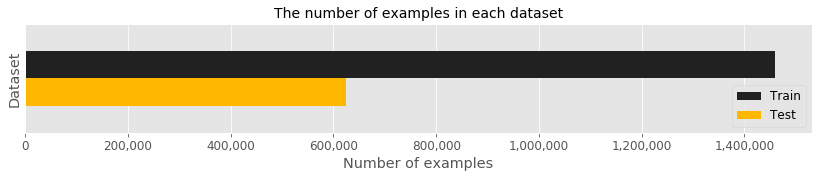

In [45]:
ax = pd.DataFrame({'Train': [n_train_rows], 'Test': [n_test_rows]}).plot.barh(
    figsize=(14.1, 2), legend='reverse', rot=90, color=[COLOR_YELLOW, COLOR_DARK])
ax.set(xlabel='Number of examples', ylabel='Dataset')
ax.set_title('The number of examples in each dataset', fontsize=14)
ax.get_yaxis().set_ticks([])
# For readability, add commas to separate thousand in the x-axis labels
ax.set_xticklabels([format(label, ',.0f') for label in ax.get_xticks()]);

# Visualizing the distributions of some variables in training and testing data by bar charts.

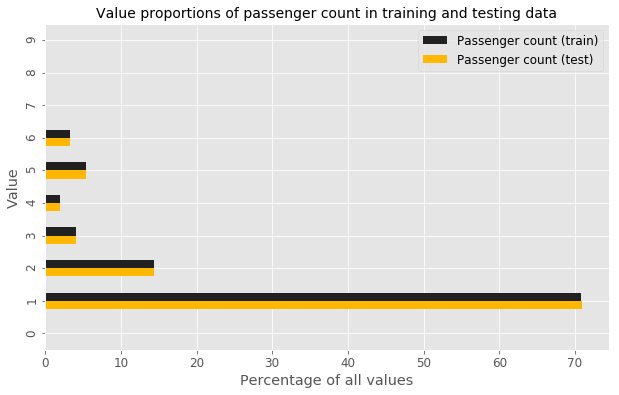

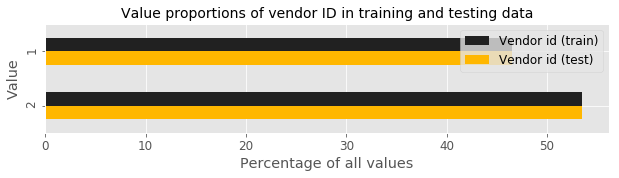

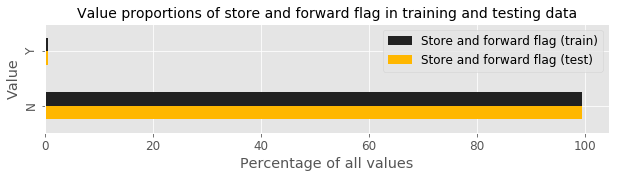

In [47]:
for col_name_pretty, col_name_official, figsize in zip(
        ['passenger count', 'vendor ID', 'store and forward flag'],
        ['passenger_count', 'vendor_id', 'store_and_fwd_flag'],
        [(14.1, 6), (14.1, 2), (14.1, 2)]):
    ax = pd.DataFrame({
        col_name_pretty.capitalize() + ' (train)':
            train[col_name_official].value_counts() /
            train[col_name_official].value_counts().sum() * 100,
        col_name_pretty.capitalize() + ' (test)':
            test[col_name_official].value_counts() /
            test[col_name_official].value_counts().sum() * 100}).plot.barh(
        figsize=figsize, legend='reverse', rot=90, stacked=False,
        color=[COLOR_YELLOW, COLOR_DARK])
    ax.set(xlabel='Percentage of all values', ylabel='Value')
    ax.set_title('Value proportions of %s in training and testing data' % col_name_pretty,
                 fontsize=14)

# Question:
# What are the value proportions of some varibales in training and testing data?

By looking at the above plots, we can make the following observations:

~70 % of the time people travel alone. The most popular way of sharing a taxi is to share it with a single friend. The second most popular way of sharing a taxi is to travel in a group of five people.

There are two vendors in the data, with the second vendor representing the majority.

Store and forward flag has almost always (99.4 % of the trips) been "No".

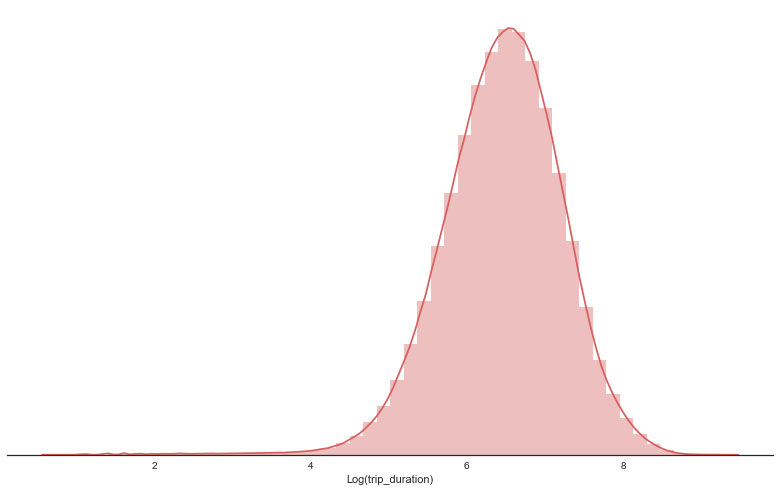

In [12]:
%matplotlib inline
import time
import seaborn as sns

sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(1, 1, figsize=(11, 7), sharex=True)
sns.despine(left=True)
sns.distplot(np.log(train['trip_duration'].values+1), axlabel = 'Log(trip_duration)', label = 'log(trip_duration)', bins = 50, color="r")
plt.setp(axes, yticks=[])
plt.tight_layout()

plt.show()



# Question: Are trip durations like Gaussian?

It is clear with the above histogram and kernel density plot that the trip-durations are like Gaussian and few trips have very large duration, like ~350000 seconds which is 100 hours (which is weird, as long as it isn't an intercity taxi ride from NYC to SF or Alaska)

D:\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


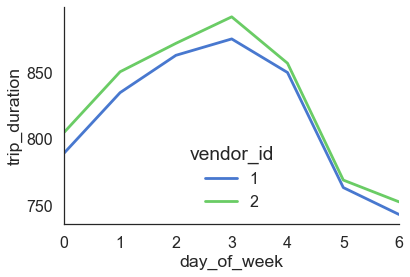

In [13]:
# Formatting datetime

train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
train.loc[:, 'pick_month'] = train['pickup_datetime'].dt.month
train.loc[:, 'hour'] = train['pickup_datetime'].dt.hour
train.loc[:, 'week_of_year'] = train['pickup_datetime'].dt.weekofyear
train.loc[:, 'day_of_year'] = train['pickup_datetime'].dt.dayofyear
train.loc[:, 'day_of_week'] = train['pickup_datetime'].dt.dayofweek
summary_wdays_avg_duration = pd.DataFrame(train.groupby(['vendor_id','day_of_week'])['trip_duration'].mean())
summary_wdays_avg_duration.reset_index(inplace = True)
summary_wdays_avg_duration['unit']=1
sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("poster")
sns.tsplot(data=summary_wdays_avg_duration, time="day_of_week", unit = "unit", condition="vendor_id", value="trip_duration")
sns.despine(bottom = False)

# Finding:
    it's clear that the vendor 1 is taking more time than vendor 2 on all the days of the week.

D:\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


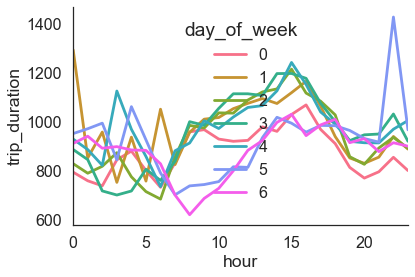

In [65]:
summary_hour_duration = pd.DataFrame(train.groupby(['day_of_week','hour'])['trip_duration'].mean())
summary_hour_duration.reset_index(inplace = True)
summary_hour_duration['unit']=1
sns.set(style="white", palette="muted", color_codes=False)
sns.set_context("poster")
sns.tsplot(data=summary_hour_duration, time="hour", unit = "unit", condition="day_of_week", value="trip_duration")
sns.despine(bottom = False)

# findings -

Its clear from the above plot that on day 0, that is Sunday and day 6 that is Saturday, the trip duration is very less that all the weekdays at 5 AM to 15 AM time.
See this, on Saturday around midnight, the rides are taking far more than usual time, this is obvious through now verified using given data

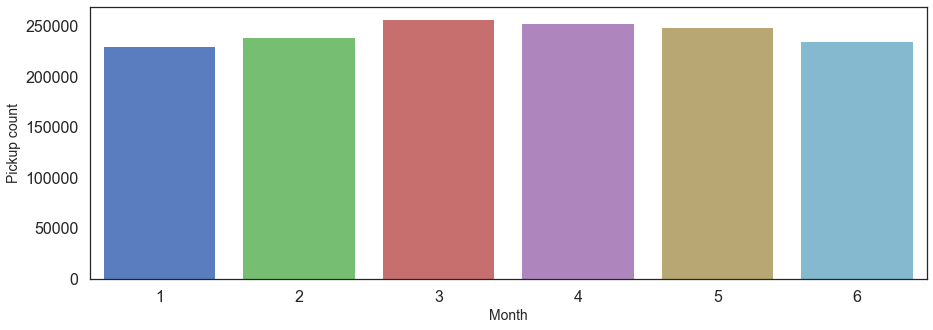

In [67]:
train['pickup_day'] = train['pickup_datetime'].dt.day
train['pickup_month'] = train['pickup_datetime'].dt.month
train['pickup_weekday'] = train['pickup_datetime'].dt.weekday
train['pickup_hour'] = train['pickup_datetime'].dt.hour

train['drop_day'] = train['dropoff_datetime'].dt.day
train['drop_month'] = train['dropoff_datetime'].dt.month
train['drop_weekday'] = train['dropoff_datetime'].dt.weekday
train['drop_hour'] = train['dropoff_datetime'].dt.hour

f = plt.figure(figsize=(15,5))
sns.countplot(x='pickup_month', data=train)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Pickup count', fontsize=14)
plt.show()

# Question: How many pickups for each month
Ans: See above bar graph

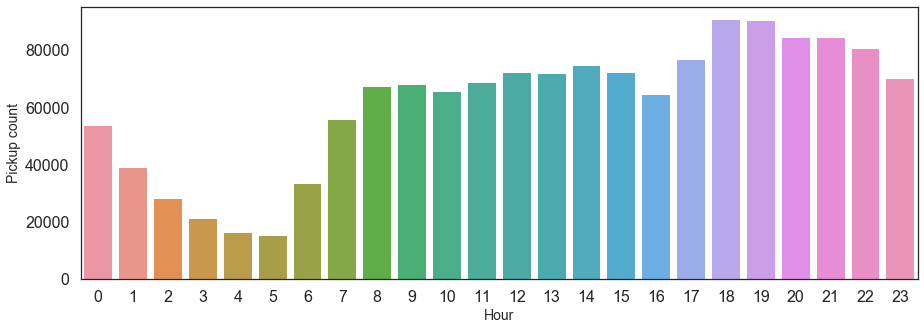

In [68]:
f = plt.figure(figsize=(15,5))
sns.countplot(x='pickup_hour', data=train)
plt.xlabel('Hour', fontsize=14)
plt.ylabel('Pickup count', fontsize=14)
plt.show()

# Question: How many pickups/hr
Ans: See above bar graph. verything looks good here too. As expected, the number of pickups gradually decreases after mid-night. The highest number of pickups are around 6pm and 7pm in the evening which makes sense as many people are on their way to home from office.

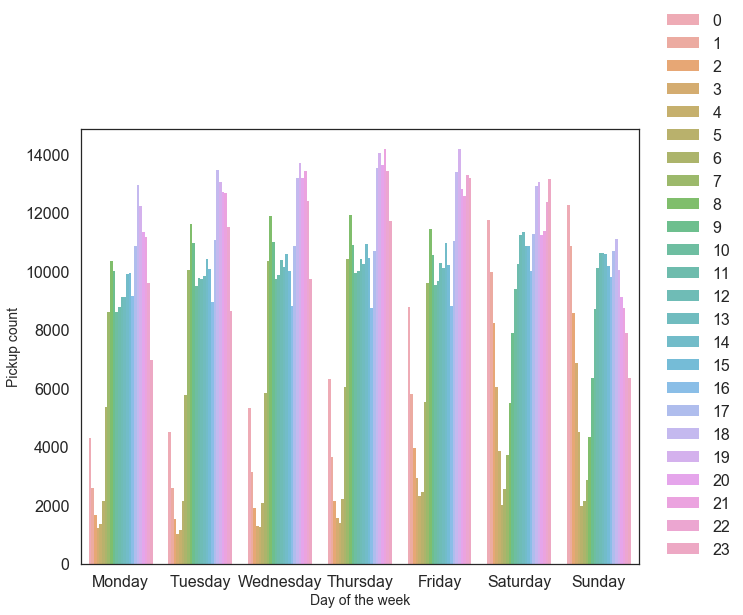

In [69]:
f = plt.figure(figsize=(10,8))
days = [i for i in range(7)]
sns.countplot(x='pickup_weekday', data=train, hue='pickup_hour', alpha=0.8)
plt.xlabel('Day of the week', fontsize=14)
plt.ylabel('Pickup count', fontsize=14)
plt.xticks(days, ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'))
plt.legend(loc=(1.04,0))
plt.show()

Ahh nice plot. Did you notice the peaks at mid-night on Saturday and Sunday? This should be fine because most of the people are doing parties on weekends.

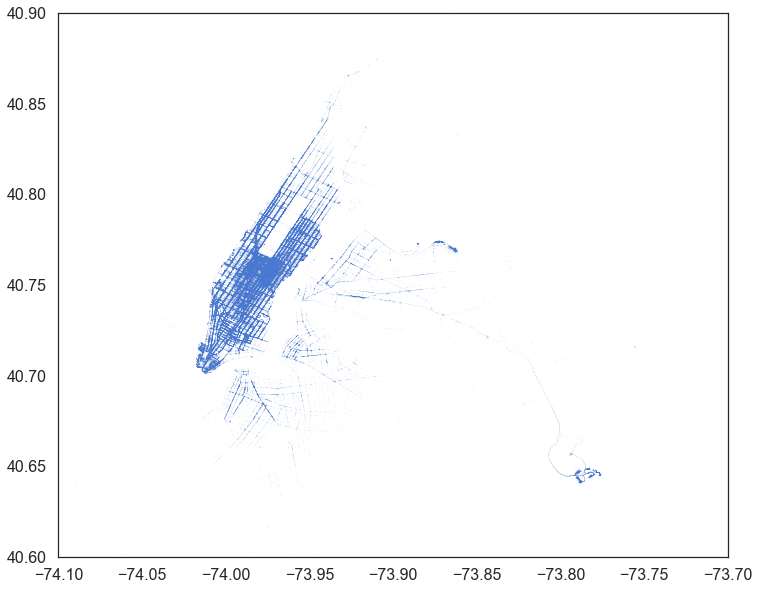

In [72]:
fig, ax = plt.subplots(ncols=1, nrows=1,figsize=(12,10))
plt.ylim(40.6, 40.9)
plt.xlim(-74.1,-73.7)
ax.scatter(train['pickup_longitude'],train['pickup_latitude'], s=0.0002, alpha=1)

Yayyy!!! Finally a scatterplot...seems like most of the riders are taken within Manhatten..the other one at bottom right seems like area around JFK airport around Queens

# Lets check some correlations on the variables

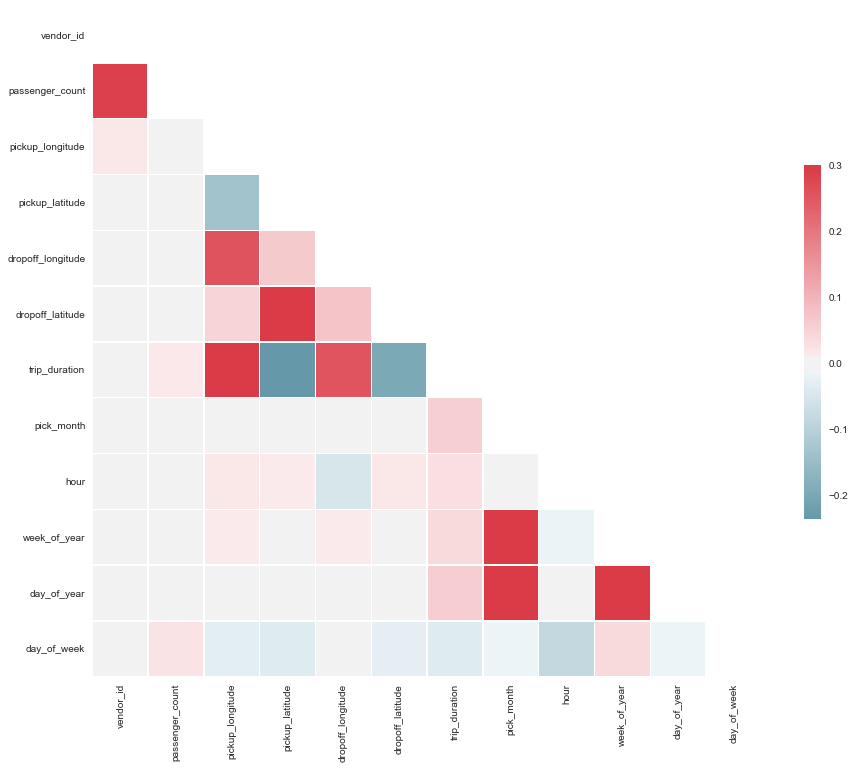

In [14]:
sns.set(style="white")

# Generate a large random dataset
temp3 = train.copy()

# Compute the correlation matrix
corr = temp3.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 13))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Findings -

The highest correlation is observed with the gollowing variables:

    Week_of_year and pick_month
    day_of_year and pick_month
    trip_duration and pickup_longitude